In [130]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style("whitegrid")

from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy import where

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import inv_boxcox   
import os #we will use the function listdir to list files in a folder
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

pd.set_option('display.max_columns', None)

### Extracting the data

In [71]:
data = pd.read_csv('measurements.csv', header=None)
# we create a copy that we will use to train the model and have a reference point
print(data.shape)
data.head()

(389, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
1,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
2,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
3,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
4,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN


### Data Cleaning

In [72]:
# Useful functions

# Checking the NaNs
def check_nan(df):
    nulls = pd.DataFrame((df.isna().sum()/len(df))*100)
    nulls= nulls.reset_index()
    nulls.columns = ['column_name', 'Percentage Null Values']
    nulls.sort_values(by='Percentage Null Values', ascending = False)
    return nulls

# Checking the value counts
def check_count(df):
    value_counts = []
    for column in df.columns:
        x = len(df[column].value_counts())
        value_counts.append(x)
    counts = pd.DataFrame(value_counts)
    counts = counts.reset_index()
    counts.columns = ['name', 'value_counts']
    for i in range(0, df.shape[1]):
        counts['name'] = counts['name'].replace(i,df.columns[i])
    return counts

#### Renaming the column names 

In [73]:
data = data.rename(columns=data.iloc[0]).loc[1:]
data.columns = [column.replace(" ", "_") for column in data.columns] 
data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
1,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
2,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
3,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
4,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
5,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


#### Cleaning the values
We have commas instead of dots.

In [74]:
no_commas = ['distance', 'consume', 'temp_inside', 'temp_outside']

for col in no_commas:
     data[col] = data[col].str.replace(',', '.')

data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
1,28,5,26,21.5,12,NaN,E10,0,0,0,45,E10
2,12,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
3,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
4,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
5,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


#### Checking the data types

In [75]:
print(data.info())
# object types for numerical values, this has to be corrected
wrong_dtype = ['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'refill_liters']
data[wrong_dtype] = data[wrong_dtype].apply(pd.to_numeric, errors='coerce')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 1 to 388
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    object
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    object
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    object
 8   rain           388 non-null    object
 9   sun            388 non-null    object
 10  refill_liters  13 non-null     object
 11  refill_gas     13 non-null     object
dtypes: object(12)
memory usage: 36.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 1 to 388
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   cons

#### Dealing with the NaNs

In [76]:
# checking for NaNs
nans = check_nan(data)
nans

,column_name,Percentage Null Values
0,distance,0.000000
1,consume,0.000000
2,speed,0.000000
3,temp_inside,3.092784
4,temp_outside,0.000000
5,specials,76.030928
6,gas_type,0.000000
7,AC,0.000000
8,rain,0.000000
9,sun,0.000000


In [77]:
# exploring `specials`
print(list(data.specials.unique()))
# there's a lot of repetitive data
# we already have boolean columns with AC, rain and snow so we can just drop this column
data = data.drop('specials', axis=1)

[nan, 'AC rain', 'AC', 'rain', 'snow', 'AC snow', 'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun', 'ac rain']


In [78]:
# dropping this columns as they are mostly empty
print(list(data.refill_liters.unique()))
print(list(data.refill_gas.unique()))
data = data.drop(['refill_liters', 'refill_gas'], axis=1)

[45.0, nan, 38.0, 10.0, 39.0, 41.0, 37.0]
['E10', nan, 'SP98']


In [79]:
# exploring temp_inside
print(list(data.temp_inside.unique()))
print(list(data.temp_inside.value_counts()))

# there are not too many null values, let's replace the NaNs with the mean temp_inside
data.fillna(round(data.mean(), 1), inplace=True)
print(list(data.temp_inside.unique()))
print(list(data.temp_inside.value_counts()))

[21.5, 22.5, 20.0, nan, 21.0, 20.5, 23.0, 23.5, 25.0, 24.0, 22.0, 19.0, 24.5, 25.5]
[133, 102, 59, 25, 13, 13, 12, 7, 4, 3, 2, 2, 1]
[21.5, 22.5, 20.0, 21.9, 21.0, 20.5, 23.0, 23.5, 25.0, 24.0, 22.0, 19.0, 24.5, 25.5]
[133, 102, 59, 25, 13, 13, 12, 12, 7, 4, 3, 2, 2, 1]


In [80]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
1,28.0,5.0,26,21.5,12,E10,0,0,0
2,12.0,4.2,30,21.5,13,E10,0,0,0
3,11.2,5.5,38,21.5,15,E10,0,0,0
4,12.9,3.9,36,21.5,14,E10,0,0,0
5,18.5,4.5,46,21.5,15,E10,0,0,0


#### Checking the value counts

In [82]:
counts = check_count(data)
counts

,name,value_counts
0,distance,174
1,consume,43
2,speed,60
3,temp_inside,14
4,temp_outside,33
5,gas_type,2
6,AC,2
7,rain,2
8,sun,2


### Exploratory Data Analysis

In [107]:
## Useful functions - EDA

def check_dist(df, a, b):
    # initialize plot counter
    c = 1 
    fig = plt.figure(figsize = (16, 14))
    
    # iterate over the columns on the subplot grid
    for column in df.columns:
        plt.subplot(a, b, c)
        plt.title('{}'.format(column, a, b, c))
        plt.xlabel(column)
        sns.distplot(df[column])
        c = c + 1
    plt.tight_layout()
    plt.show()
    return ()


# Do the same with continuous variables 
def scatter(df, target, a, b):
    # initialize plot counter
    c = 1 
    fig = plt.figure(figsize = (16, 14))
    
    # exclude the target
    cols_to_include = df.loc[:, df.columns != target]
    
    # iterate over the columns on the subplot grid
    for column in cols_to_include:
        plt.subplot(a, b, c)
        plt.title('{}'.format(column, a, b, c))
        plt.xlabel(column)
        sns.scatterplot(df[column], df[target])
        c = c + 1
    plt.tight_layout()
    plt.show()
    return ()

def boxplot(df, a, b):
    # initialize plot counter
    c = 1 
    fig = plt.figure(figsize = (16, 14))
    
    # iterate over the columns on the subplot grid
    for column in df.columns:
        plt.subplot(a, b, c)
        plt.title('{}'.format(column, a, b, c))
        plt.xlabel(column)
        sns.boxplot(x=df[column])
        c = c + 1
    plt.tight_layout()
    plt.show()
    return ()
        
def heatmap(df):
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(df.corr(), mask=mask, annot=True, cmap='Blues')
    m = ax.get_figure()
    plt.show()
    return m

def countplot(df, a, b):
    # initialize plot counter
    c = 1 
    fig = plt.figure(figsize = (16, 14))
    
    # iterate over the columns on the subplot grid
    for column in df.columns:
        plt.subplot(a, b, c)
        plt.title('{}'.format(column, a, b, c))
        plt.xlabel(column)
        sns.countplot(x=df[column], palette='Blues')
        c = c + 1
    plt.tight_layout()
    plt.show()
    return ()

#### Separating the numerical and categorical data

In [84]:
# creating a dataframe with only the numerical data for EDA - including `bathrooms`, `floors`, and `bedrooms`
numericals =  data.select_dtypes(np.number)

# creating a dataframe with only the categorical data
cat = data.select_dtypes(np.object)

#### Exploring the numerical data

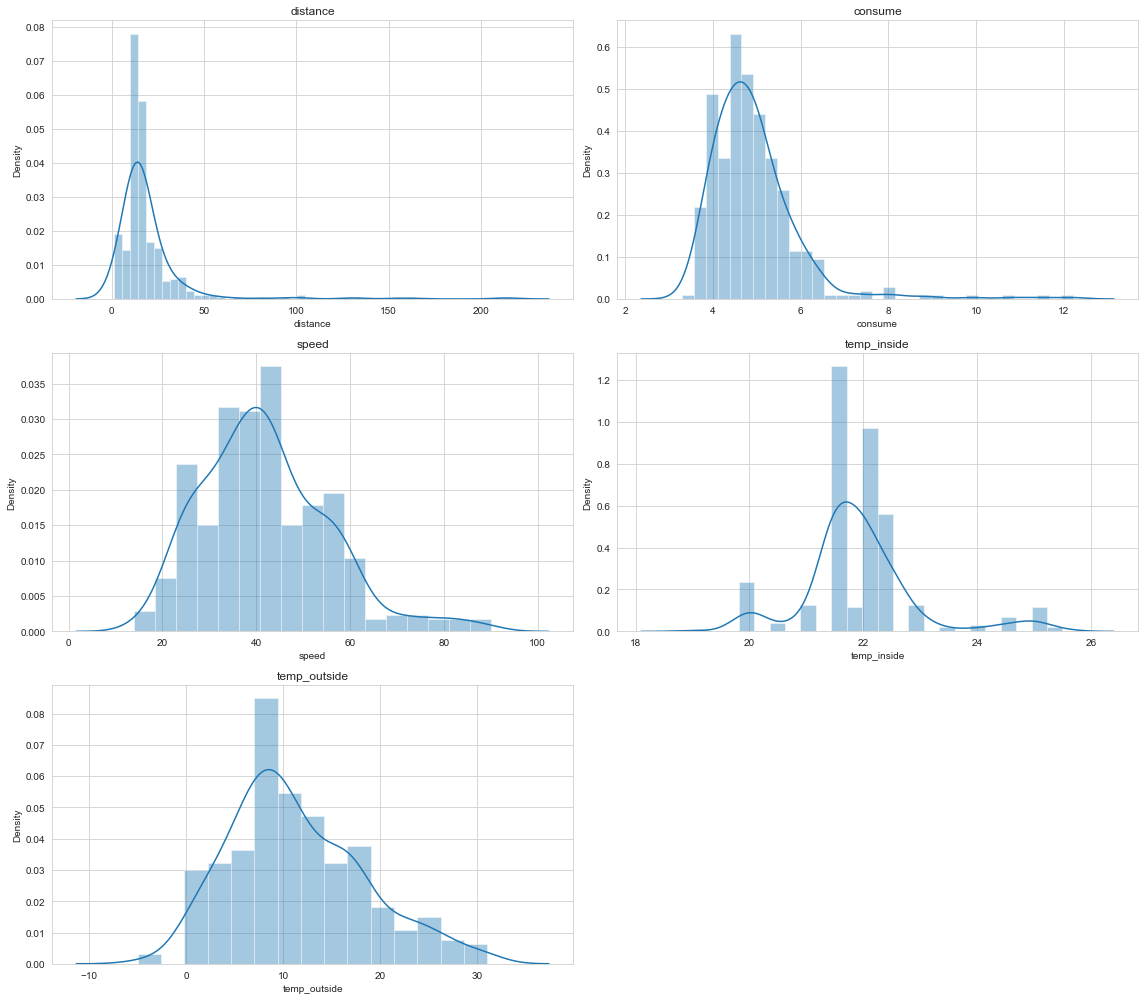

In [88]:
distributions = check_dist(numericals, 3, 2)

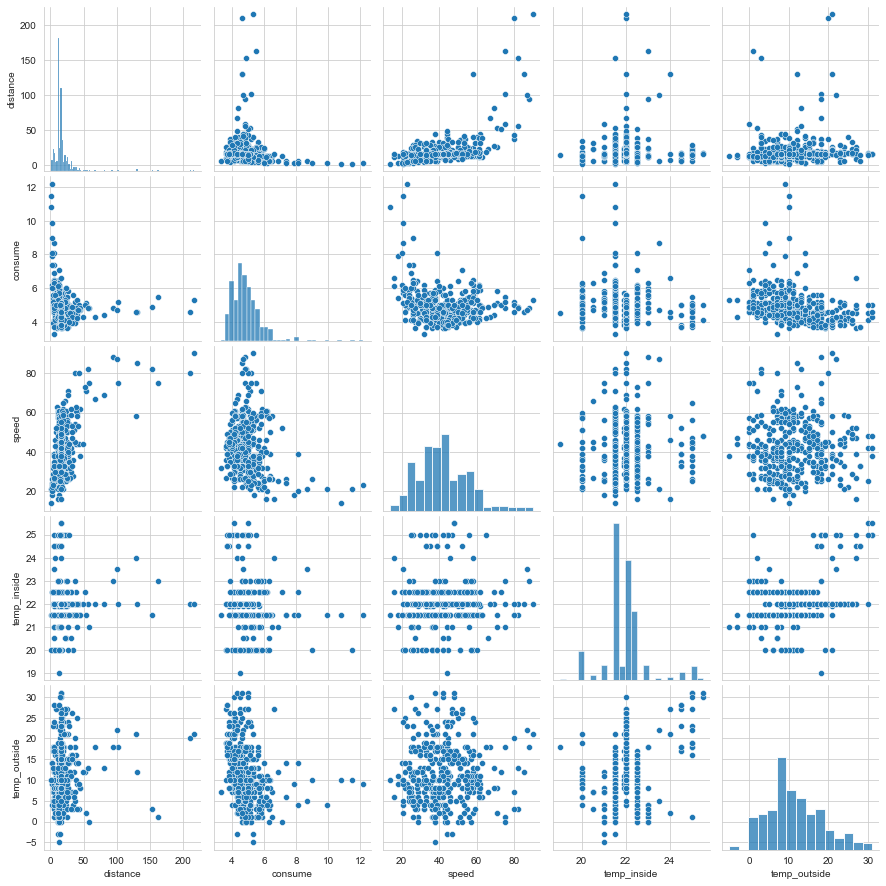

In [92]:
sns.pairplot(numericals)
# no obvious stong correlations between the variables
# only some correlation between speed, distance and consume

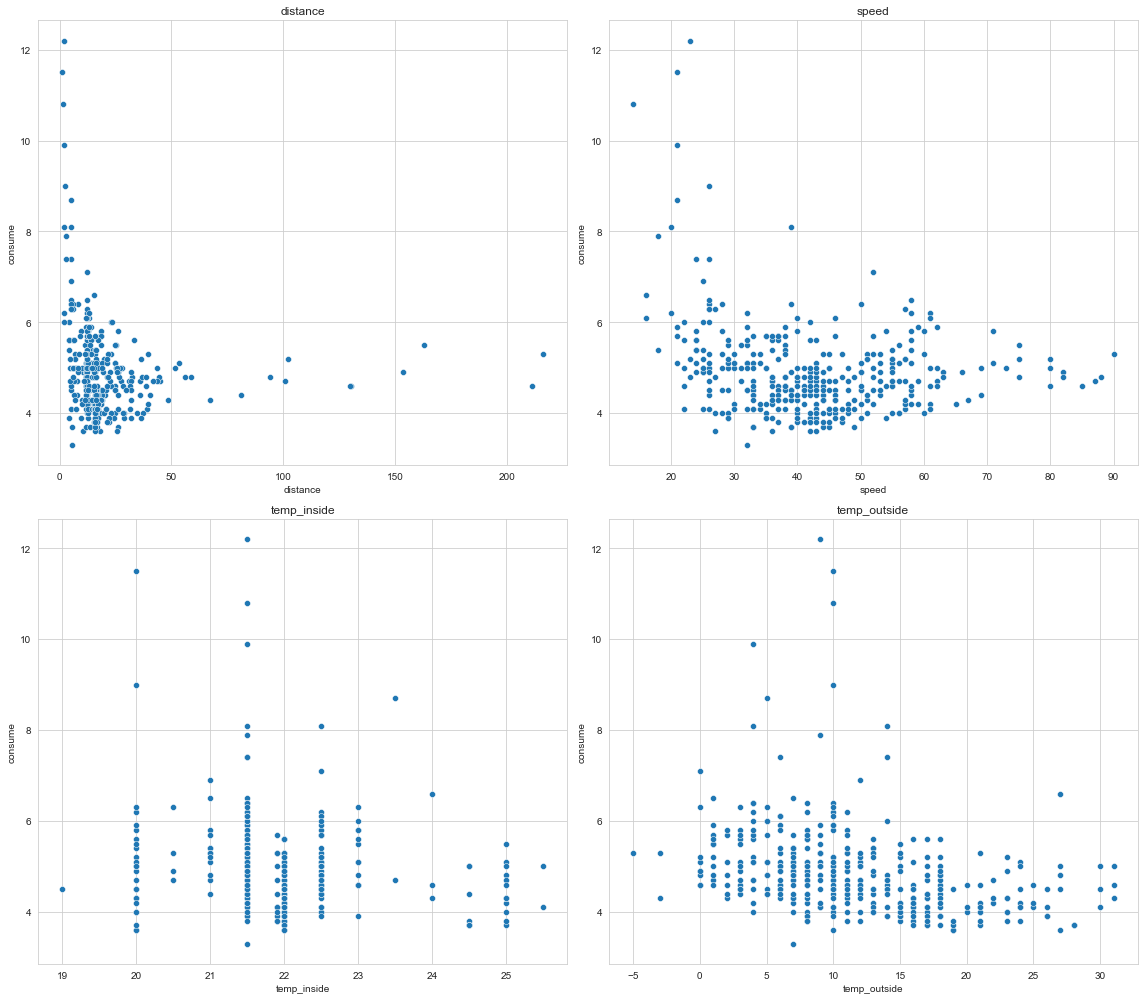

In [94]:
scatterplots = scatter(numericals, 'consume', 2, 2)
# the consumption is higher when the vehicle starts

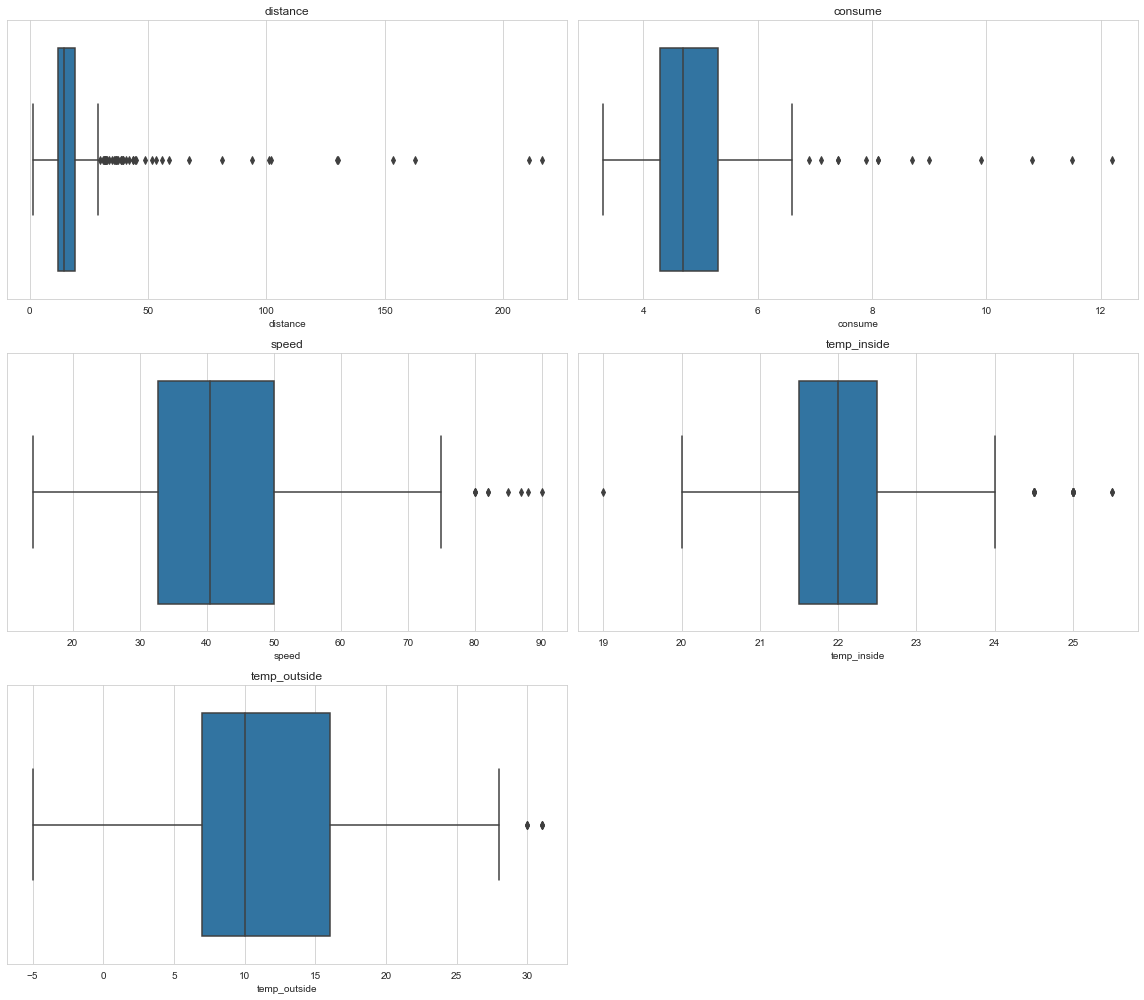

In [95]:
boxplots = boxplot(numericals, 3, 2)

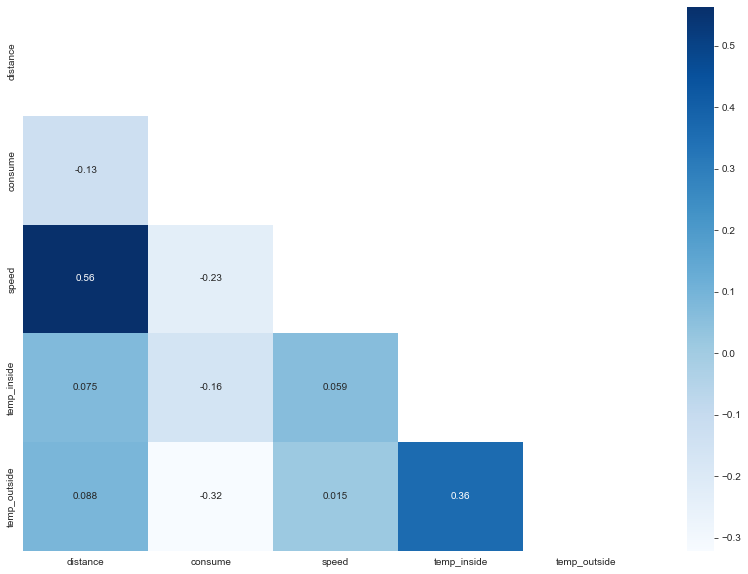

In [98]:
map_1 = heatmap(numericals)
# multicolinearity detected
# strongest correlations between speed and distance, temp_outside and temp_inside

#### Exploring the categorical data

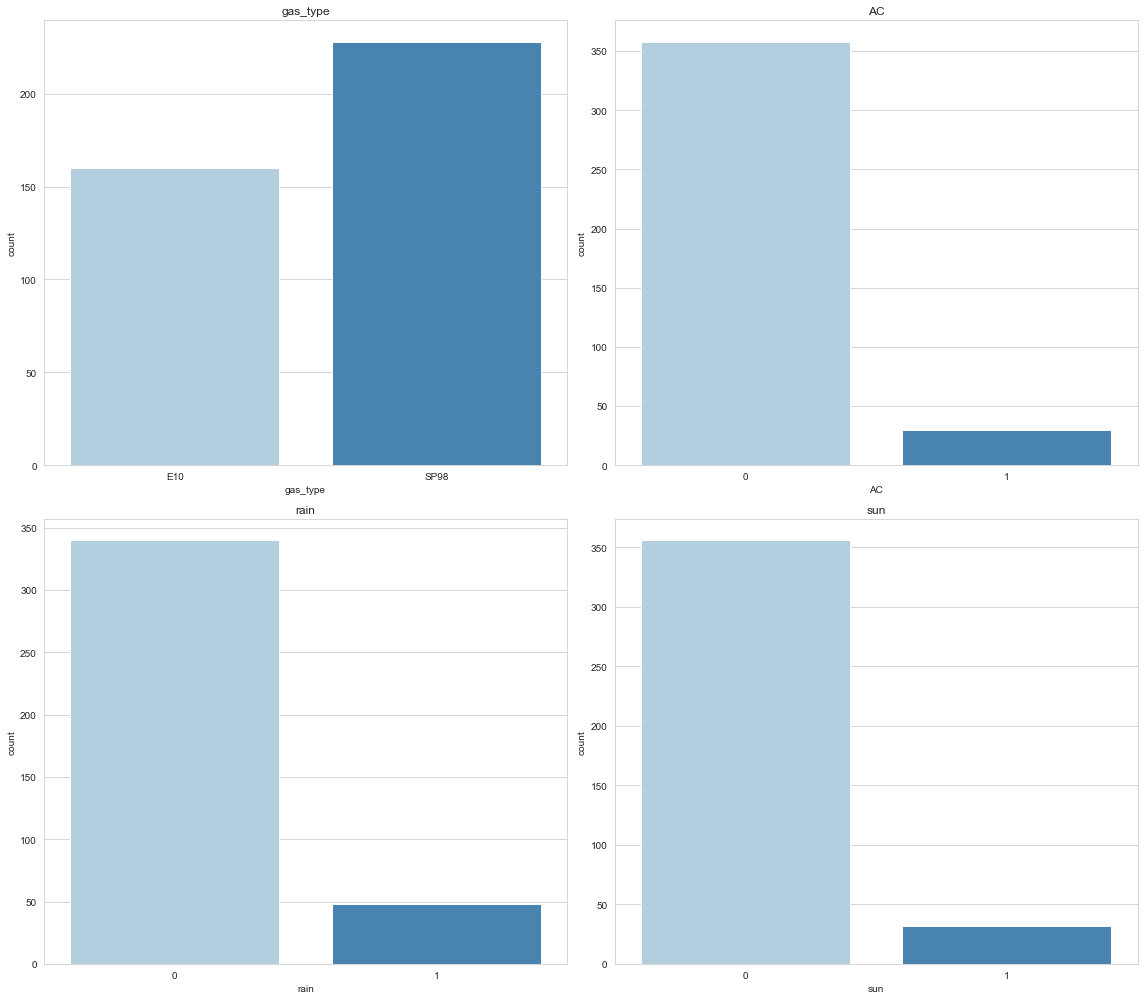

In [103]:
countplots = countplot(cat, 2, 2)

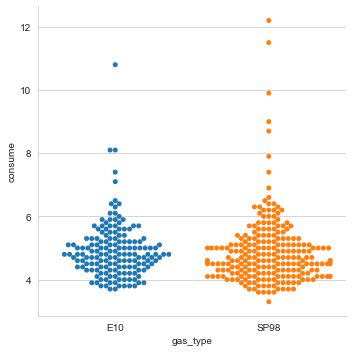

In [111]:
sns.catplot(x="gas_type", y="consume", kind='swarm', data=data)

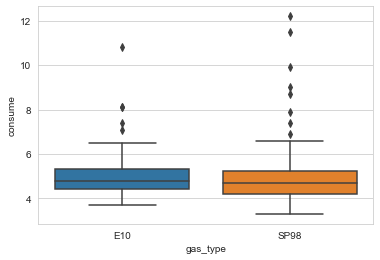

In [183]:
ax = sns.boxplot(x="gas_type", y="consume", data=data)

In [113]:
data.gas_type.value_counts()
# we're also dealing with some data imbalance

SP98    228
E10     160
Name: gas_type, dtype: int64

###### Which features have a real impact on the consumption?

In [119]:
def check_corr_target(df, target):
    correlated = []
    not_correlated = []

    for col in df.columns:
        ct_table_ind_=pd.crosstab(df[col], df[target])
        chi2_stat_, p_, dof_, expected_ = stats.chi2_contingency(ct_table_ind_)
        prob = 0.95
        critical_ = chi2.ppf(prob, dof_)
        if abs(chi2_stat_) >= critical_:
            correlated.append(col)
        else:
            not_correlated.append(col)
    
    print('the correlated features are: ', correlated)
    print('the non-correlated features are: ', not_correlated)

In [120]:
gas_corr = check_corr_target(data, target = 'consume')

the correlated features are:  ['distance', 'consume', 'speed', 'temp_inside', 'AC', 'rain']
the non-correlated features are:  ['temp_outside', 'gas_type', 'sun']


##### Double checking with t test

Null hypothesis: E10 consumption = SP98 consumption\
Alternate hypothesis: E10 consumption =/= SP98 consumtion\
Level of significance: 0.05

In [128]:
# extracting the consume value for E10
e10 = data[data['gas_type'] == 'E10']
e10 = e10.consume.array
print(e10)

# extracting the consume value for SP98
sp98 = data[data['gas_type'] == 'SP98']
sp98 = sp98.consume.array
print(sp98)

<PandasArray>
[5.0, 4.2, 5.5, 3.9, 4.5, 6.4, 4.4, 5.0, 6.4, 5.3,
 ...
 4.1, 4.0, 3.8, 3.8, 3.8, 5.1, 4.0, 4.8, 3.9, 4.6]
Length: 160, dtype: float64
<PandasArray>
[3.3, 9.9, 5.1, 4.9, 4.9, 4.7, 5.1, 4.9, 4.2, 6.1,
 ...
 4.4, 3.8, 5.0, 3.7, 3.7, 3.7, 4.3, 3.8, 4.6, 5.0]
Length: 228, dtype: float64


In [134]:
# find the variance of each gas
print(np.var(e10), np.var(sp98))
np.var(e10)/np.var(sp98)

# the ratio is < 4 so we can assume that the population variances are equal

0.8066484375000001 1.2453501077254547


0.6477282432434099

In [135]:
ttest_ind(e10, sp98, equal_var=True)

Ttest_indResult(statistic=0.3011626300254617, pvalue=0.7634526478628367)

**Observations**

The p value 0.76 in our test is greater than the level of significance 0.05, which means the test statistic falls in the region between the critical regions. \
We fail to reject the Null Hypothesis.

### Feature Engineering

##### Creating a new column with the kilometers per liter: `kpl`

In [148]:
data['kpl'] = round(data['distance']/data['consume'], 1)
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,kpl
1,28.0,5.0,26,21.5,12,E10,0,0,0,5.6
2,12.0,4.2,30,21.5,13,E10,0,0,0,2.9
3,11.2,5.5,38,21.5,15,E10,0,0,0,2.0
4,12.9,3.9,36,21.5,14,E10,0,0,0,3.3
5,18.5,4.5,46,21.5,15,E10,0,0,0,4.1


In [182]:
print('E10 consumes an average of', round(data[data['gas_type'] == 'E10']['kpl'].mean(), 2), 'kilometer per liter.')
print('SP98 consumes an average of', round(data[data['gas_type'] == 'SP98']['kpl'].mean(), 2), 'kilometer per liter.')
print('Average consumption difference is', round(data[data['gas_type'] == 'E10']['kpl'].mean() - data[data['gas_type'] == 'SP98']['kpl'].mean(), 2), 'kilometer per liter.')
print()
print('E10 consumed an average of', round(data[data['gas_type'] == 'E10']['consume'].mean(), 2), 'liters.')
print('SP98 consumes an average of', round(data[data['gas_type'] == 'SP98']['consume'].mean(), 2), 'liters.')
print('Average consumption difference is', round(data[data['gas_type'] == 'E10']['consume'].mean() - data[data['gas_type'] == 'SP98']['consume'].mean(), 2), 'liters.')

E10 consumes an average of 4.47 kilometer per liter.
SP98 consumes an average of 4.01 kilometer per liter.
Average consumption difference is 0.46 kilometer per liter.

E10 consumed an average of 4.93 liters.
SP98 consumes an average of 4.9 liters.
Average consumption difference is 0.03 liters.


One liter of E10 takes a car 0.46 km further than SP98.

#### Let's explore the correlation between `kpl` and the gas types

With chi-square test

In [184]:
data_ = data.copy()
data_.drop(['consume', 'distance'], axis=1, inplace=True)
gas_corr_2 = check_corr_target(data_, target = 'kpl')

the correlated features are:  ['speed', 'temp_inside', 'kpl']
the non-correlated features are:  ['temp_outside', 'gas_type', 'AC', 'rain', 'sun']


With the t test

In [150]:
# extracting the consume value for E10
e10_ = data[data['gas_type'] == 'E10']
e10_ = e10_.kpl.array
print(e10_)

# extracting the consume value for SP98
sp98_ = data[data['gas_type'] == 'SP98']
sp98_ = sp98_.kpl.array
print(sp98_)

<PandasArray>
[5.6, 2.9, 2.0, 3.3, 4.1, 1.3, 1.8, 2.5, 0.8, 2.2,
 ...
 3.8, 4.0, 5.5, 4.1, 4.2, 3.2, 4.0, 3.2, 4.4, 3.6]
Length: 160, dtype: float64
<PandasArray>
[1.6, 0.2, 2.8, 3.3, 2.4, 5.8, 2.3, 2.2, 2.8, 2.1,
 ...
 3.7, 4.4, 1.7, 1.5, 3.7, 4.3, 3.7, 4.2, 3.3, 2.9]
Length: 228, dtype: float64


In [151]:
# find the variance of each gas
print(np.var(e10_), np.var(sp98_))
np.var(e10_)/np.var(sp98_)

# the ratio is < 4 so we can assume that the population variances are equal

18.92354843750001 24.0826700523238


0.7857745173764081

In [152]:
ttest_ind(e10_, sp98_, equal_var=True)

Ttest_indResult(statistic=0.9582000087307115, pvalue=0.3385616825322666)

Once again we fail to reject the Null Hypothesis.

### Vizualizing `kpl`

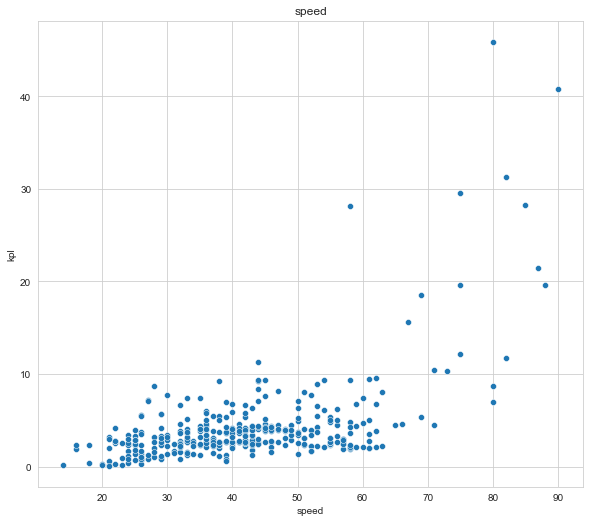

In [190]:
num = data_.select_dtypes(np.number)
cats = data_.select_dtypes(object)
scatterplots = scatter(num[['speed', 'kpl']], 'kpl', 2, 2)
# the consumption is higher when the vehicle starts

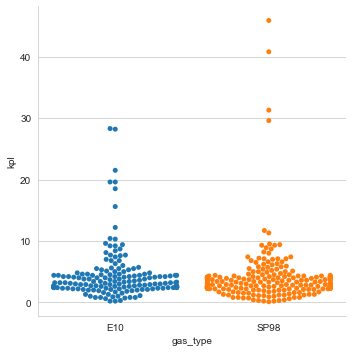

In [191]:
sns.catplot(x="gas_type", y="kpl", kind='swarm', data=data_)

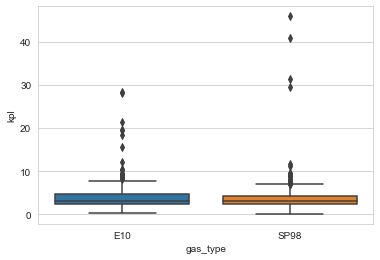

In [192]:
ax = sns.boxplot(x="gas_type", y="kpl", data=data_)

### Modeling

In [136]:
### Useful functions - preparing the data for modeling

# Log Transform
def log_transfom_x(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.nan

def log_transform_df(df, a, b):
    # initialize plot counter
    c = 1 
    fig = plt.figure(figsize = (16, 14))
    
    numerical = df.select_dtypes(np.number)
    columns = numerical.columns
    
    for column in columns:
        df[column] = list(map(log_transfom_x, df[column]))
        
    for column in columns:
        df[column] = df[column].fillna(np.mean(df[column]))
        
        plt.subplot(a, b, c)
        plt.title('{}'.format(column, a, b, c))
        plt.xlabel(column)
        sns.distplot(df[column], fit=norm)
        c = c + 1
        
    plt.tight_layout()
    plt.show()
    
    return df

# I will use this function to scale the data with StandardScaler
def standard_scaling(df):
    transformer = StandardScaler().fit(df)
    x_standardized = transformer.transform(df)
    X = pd.DataFrame(x_standardized)
    X.columns = df.columns
    return X

# Encoding the categoricals
def encode_cat(df):
    encoder = OneHotEncoder(drop='first').fit(df)
    column_names = encoder.get_feature_names(list(df.columns))
    encoded_categorical = encoder.transform(df).toarray()
    encoded_categorical = pd.DataFrame(encoded_categorical, columns=column_names)
    return encoded_categorical

In [166]:
#### Useful functions - modeling and model evaluation

# general modeling function
def modeling(df, target, log, a, b, models=[], test_size=0.3):
    
    # scaling the numerical data
    X_scaled = standard_scaling(df.select_dtypes(np.number))

    # selecting the useable categorical data
    cat = df.select_dtypes(object)
    cat_encoded = pd.get_dummies(cat, columns=cat.columns, drop_first=True)


    cat_encoded.reset_index(drop=True, inplace=True)
    X_scaled.reset_index(drop=True, inplace=True)

    X = pd.concat([X_scaled, cat_encoded], axis=1)
    X = X.drop(target, axis=1)
    y = df[target]
    
    # initialize plot counter
    c = 1 
    fig = plt.figure(figsize = (16, 14))
    
    for model in models:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model.fit(X_train, y_train )
        predictions = model.predict(X_test)
        
        r2 = r2_score(y_test, predictions)
        r2_adj = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        RMSE = mean_squared_error(y_test, predictions, squared=False)
        MSE = mean_squared_error(y_test, predictions)
        MAE = mean_absolute_error(y_test, predictions)
        print(model, 'metrics are: '), print("R2 =", round(r2,2)), print("R2 adjusted =", round(r2_adj,2)), print("RMSE =", round(RMSE,2)), print("MSE =", round(MSE,2)), print("MAE =", round(MAE,2))
        print()
        
        results = pd.DataFrame()
        if log == 'yes':
            results['true'] = np.exp(y_test)
            results['pred'] = np.exp(predictions)
        else:
            results['true'] = y_test
            results['pred'] = predictions
        results['diff'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
        print('Predictions vs. Real Values - best predictions:')
        print(results.sort_values('diff', ascending=True).head(10))
        print()
        print('Predictions vs. Real Values - worst predictions:')
        print(results.sort_values('diff', ascending=False).head(10))
        print()
        
        plt.subplot(a, b, c)
        plt.title('{}'.format(f'{model}: R2 = {round(r2,2)}', a, b, c))
        plt.xlabel('true')
        plt.ylabel('pred')
        sns.regplot(x=results['true'], y=results['pred'])
        c = c + 1
        print()
    
    plt.tight_layout()
    plt.show()
        
    return predictions

### Predicting `MPG`

#### Let's create two datasets, one for each gas type

In [155]:
data_e10 = data_[data_['gas_type'] == 'E10']
data_e10.drop('gas_type', axis=1, inplace=True)
data_sp98 = data_[data_['gas_type'] == 'SP98']
data_sp98.drop('gas_type', axis=1, inplace=True)

#### Creating a benchmark model

LinearRegression() metrics are: 
R2 = 0.37
R2 adjusted = 0.28
RMSE = 3.14
MSE = 9.87
MAE = 2.11

Predictions vs. Real Values - best predictions:
     true      pred      diff
147   4.6  4.590943  0.009057
254   4.4  4.432572  0.032572
43    2.5  2.549824  0.049824
331   9.4  9.321097  0.078903
267   4.0  4.147133  0.147133
336   4.4  4.759017  0.359017
151   4.2  4.603814  0.403814
141   2.7  3.150254  0.450254
178   2.7  3.154896  0.454896
20    2.5  2.976067  0.476067

Predictions vs. Real Values - worst predictions:
     true       pred       diff
190  28.3  13.641820  14.658180
25    2.1   7.716975   5.616975
13    2.1   7.484548   5.384548
244   2.1   7.223098   5.123098
156   7.0  11.126972   4.126972
17    6.0   2.052415   3.947585
16    3.4  -0.234002   3.634002
31    2.3   5.927967   3.627967
180   3.1  -0.274730   3.374730
270   3.4   6.601624   3.201624




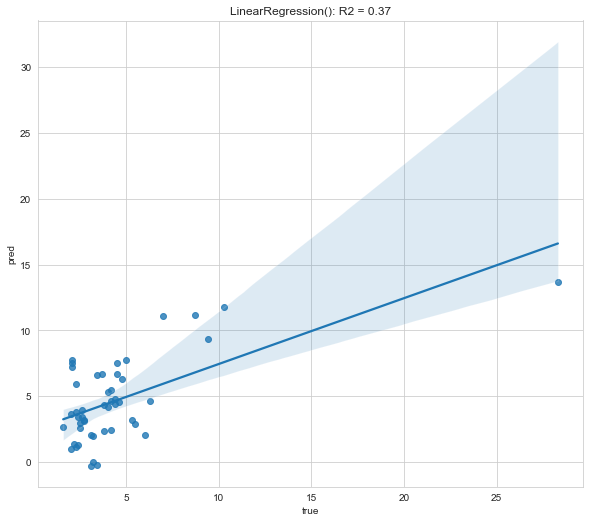

In [158]:
prediction_e10_beta = modeling(data_e10, 'kpl', 'no', 2, 2, models=[LinearRegression()], test_size=0.3)

LinearRegression() metrics are: 
R2 = -0.32
R2 adjusted = -0.45
RMSE = 2.34
MSE = 5.5
MAE = 1.82

Predictions vs. Real Values - best predictions:
     true      pred      diff
361   1.2  1.189738  0.010262
290   1.8  1.782881  0.017119
118   3.8  3.730069  0.069931
69    3.3  3.417901  0.117901
377   3.4  3.526869  0.126869
305   4.2  4.070136  0.129864
55    1.0  0.775487  0.224513
281   4.1  3.858826  0.241174
317   6.5  6.774095  0.274095
138   2.6  2.918132  0.318132

Predictions vs. Real Values - worst predictions:
     true      pred      diff
221   7.2  0.838078  6.361922
304   6.6  1.357318  5.242682
280   5.5  0.476481  5.023519
192   9.3  4.521608  4.778392
114   4.6  9.071648  4.471648
223   2.4  6.862837  4.462837
105   2.3 -2.067657  4.367657
299   3.6  7.945537  4.345537
321   7.1  2.857213  4.242787
60    2.2  6.212258  4.012258




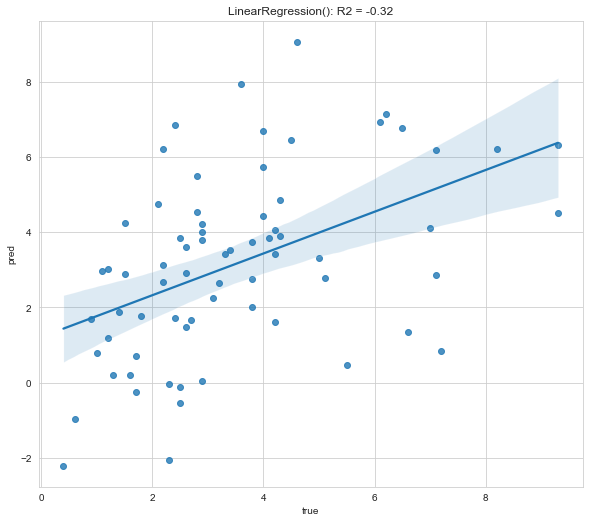

In [159]:
prediction_sp98_beta = modeling(data_sp98, 'kpl', 'no', 2, 2, models=[LinearRegression()], test_size=0.3)

### Improving the distributions with Log transform

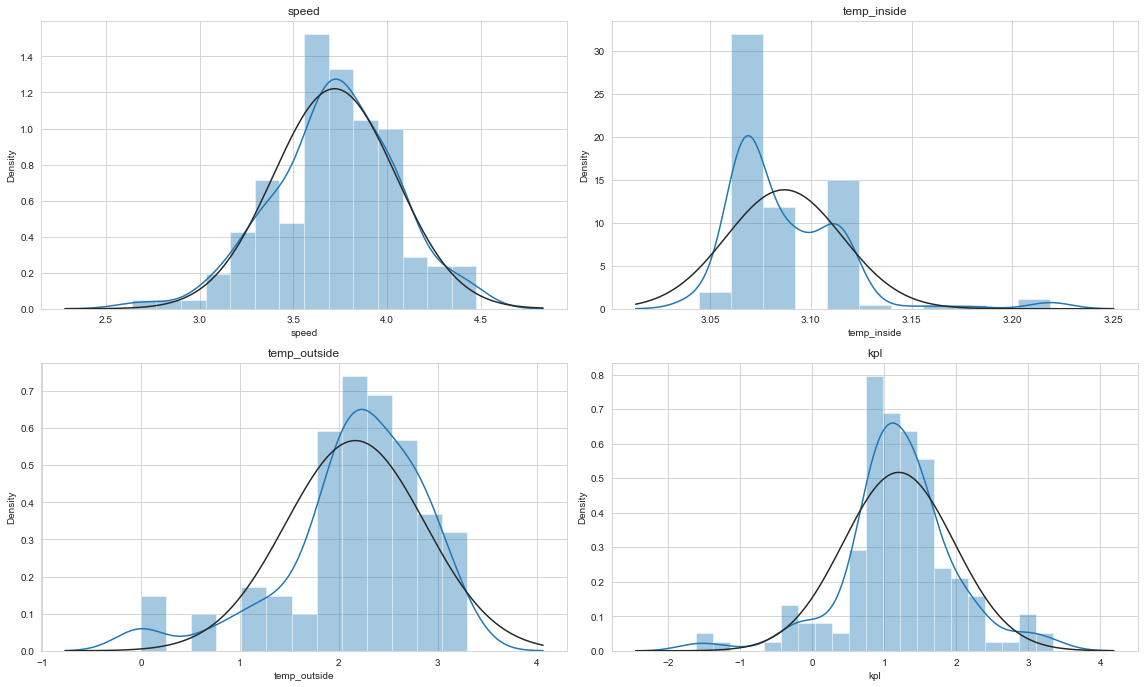

In [167]:
data_e10_log = log_transform_df(data_e10, 2, 2)

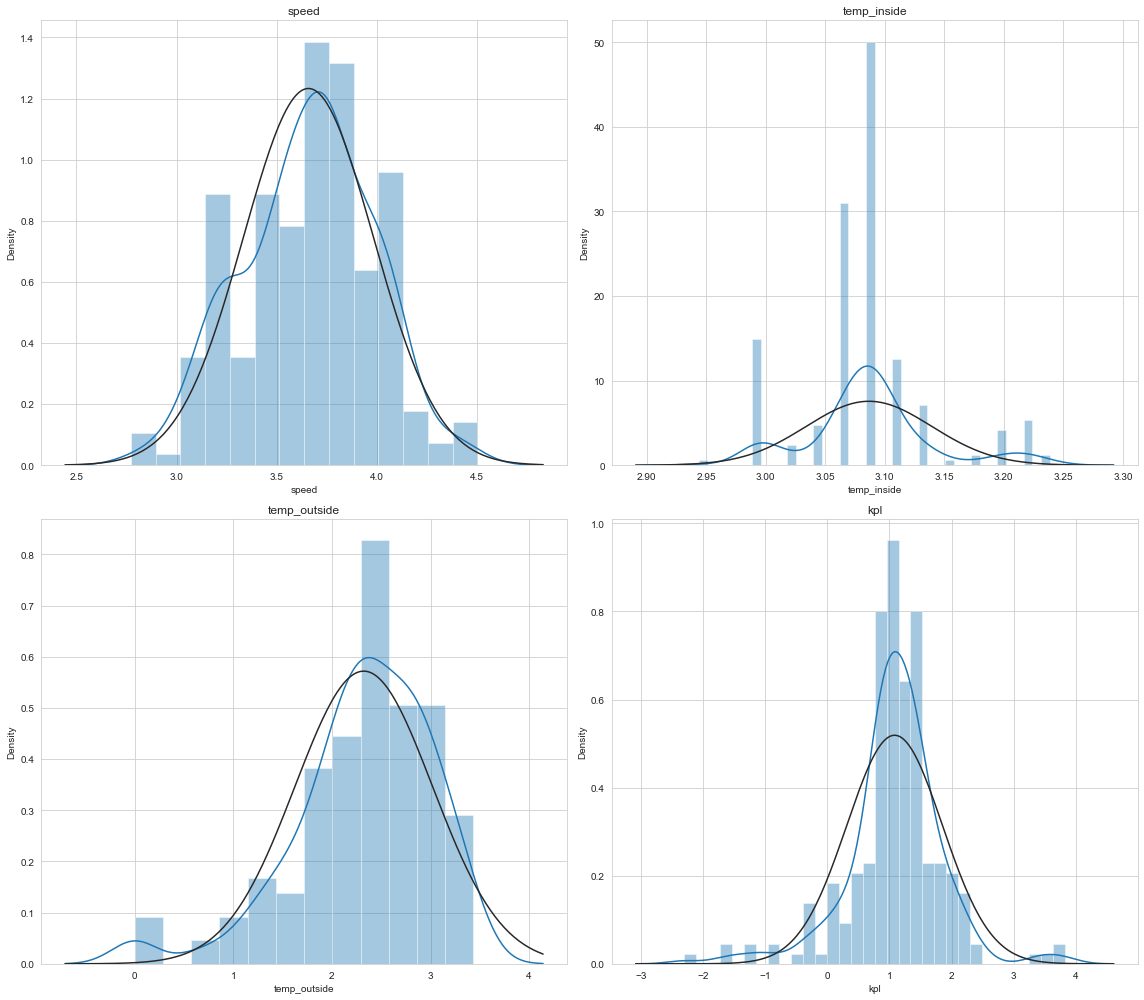

In [168]:
data_sp98_log = log_transform_df(data_sp98, 2, 2)

#### Checking the model's performance

LinearRegression() metrics are: 
R2 = 0.07
R2 adjusted = -0.06
RMSE = 0.5
MSE = 0.25
MAE = 0.39

Predictions vs. Real Values - best predictions:
     true      pred      diff
240   3.8  3.773726  0.026274
236   2.6  2.675240  0.075240
43    2.5  2.642220  0.142220
326   4.5  4.672373  0.172373
341   4.0  3.729855  0.270145
10    2.2  1.892988  0.307012
151   4.2  3.887043  0.312957
152   2.0  1.683636  0.316364
171   4.8  5.181135  0.381135
177   2.3  2.726026  0.426026

Predictions vs. Real Values - worst predictions:
     true       pred       diff
190  28.3  11.679091  16.620909
25    2.1   6.350508   4.250508
13    2.1   6.007468   3.907468
244   2.1   5.964490   3.864490
156   7.0  10.650302   3.650302
17    6.0   2.425662   3.574338
331   9.4   6.358522   3.041478
162   5.5   2.788737   2.711263
31    2.3   4.715411   2.415411
19    5.3   2.936510   2.363490




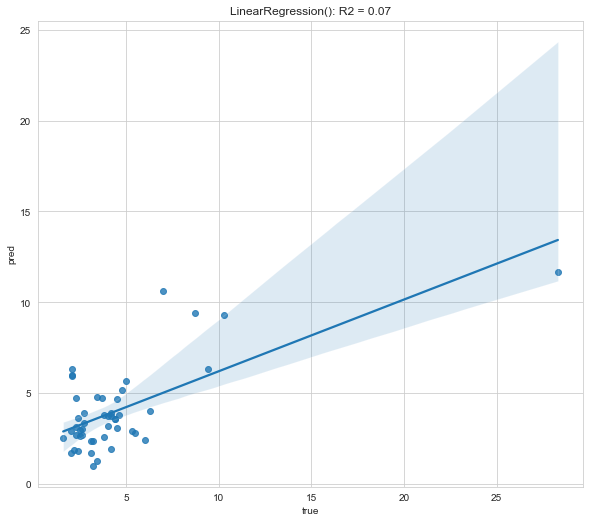

In [170]:
prediction_e10_log = modeling(data_e10_log, 'kpl', 'yes', 2, 2, models=[LinearRegression()], test_size=0.3)

LinearRegression() metrics are: 
R2 = 0.18
R2 adjusted = 0.1
RMSE = 0.57
MSE = 0.33
MAE = 0.44

Predictions vs. Real Values - best predictions:
     true      pred      diff
290   1.8  1.797741  0.002259
222   2.4  2.343247  0.056753
193   2.9  2.962175  0.062175
205   1.6  1.698271  0.098271
357   4.0  4.112683  0.112683
111   2.2  2.327451  0.127451
114   4.6  4.758215  0.158215
384   4.3  4.112386  0.187614
138   2.6  2.402768  0.197232
64    1.3  1.507145  0.207145

Predictions vs. Real Values - worst predictions:
     true      pred      diff
192   9.3  3.338128  5.961872
287   9.3  3.999577  5.300423
221   7.2  1.938573  5.261427
321   7.1  2.100956  4.999044
304   6.6  2.061728  4.538272
210   7.0  2.559514  4.440486
373   8.2  4.260314  3.939686
280   5.5  1.703931  3.796069
284   7.1  4.343395  2.756605
209   5.0  2.269873  2.730127




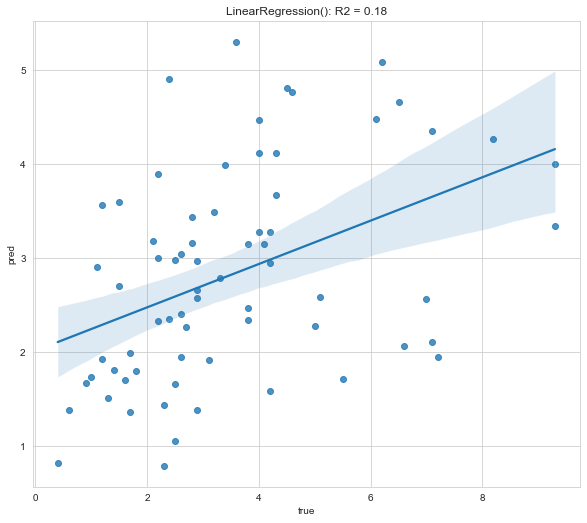

In [171]:
prediction_sp98_log = modeling(data_sp98_log, 'kpl', 'yes', 2, 2, models=[LinearRegression()], test_size=0.3)

**Observations**

It's improved the model for sp98 but not for e10.

## Conclusion

Overall the models are very bad at predicting the KPL, it might only improve by engineering new features or getting more data.\
For example, it would be interesting to know if the journey was an urban trip or not as some cars and some fuels are better for one or the other.

What we've learned so far is that there is stastically no impact on the number of liters consumed or the kilometers per liter between E10 and SP98.

The features that stastically have a correlation with the number of liter consumed are: 'distance', 'speed', 'temp_inside', 'AC', 'rain'.

The features that stastically have an impact on the kilometers per liter are:: 'speed', 'temp_inside'.

E10 consumes an average of 4.47 kilometer per liter.\
SP98 consumes an average of 4.01 kilometer per liter.\
Average consumption difference is 0.46 kilometer per liter.

E10 consumed an average of 4.93 liters.\
SP98 consumes an average of 4.9 liters.\
Average consumption difference is 0.03 liters.

One liter of E10 takes a car 0.46 km further than SP98, which makes a difference for urban journeys.